Hugo Queinnec & Corentin Royer

---
# Projet "Estimation du noyau de flou affectant une image"
### IMA201 &mdash; Saïd Ladjal  &mdash; du  23-09-2020 au 26-11-2020


In [1]:
#Imports pour tout le projet
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as skio
import skimage.restoration
import scipy.signal
import platform
import tempfile
import os

#plt.rcParams['figure.dpi']=300
#plt.rcParams['text.color']= 'white'

## 1. Introduction
Nous allons ici réaliser l'implementation d'une partie de l'algorithme de Goldstein-Fattal [1] pour le défloutage d'image. Cet algorithme calcule le noyau de flou qui a été appliqué à l'image uniquement à partir de l'image floutée.

L'algorithme se compose de deux grandes parties : dans un premier temps, on calcule la densité spectrale de puissance du noyau de flou, puis on calcule la phase de ce noyau de flou.
Nous implementerons la deuxième partie de cet algorithme qui consite à retrouver la phase de la transformée de Fourier du noyau de flou en connaissant au préalable son module.
Cette partie se décompose en deux algorithmes : *singlePhaseRetrieval* et *phaseRetrieval*, ils seront décrits et implementés respectivement dans les sections 3 et 4 de ce notebook.


[1] Jérémy Anger, Gabriele Facciolo, and Mauricio Delbracio, Estimating an Image's Blur Kernel Using Natural Image Statistics, and Deblurring it: An Analysis of the Goldstein-Fattal Method

## 2. Introduction de fonctions utiles pour la suite

Commençons par introduire quelques fonctions qui pourront nous servir par la suite dans la réalisation des tests.

Nous allons travailler à partir de noyaux de flou créés artificiellement. Nous allons donc flouter des images nettes en les convoluant avec ces noyaux de flous, et la suite de notre travail sera de retrouver l'image nette. Pour caluler l'image floue, nous utiliserons la fonction :

In [2]:
def blurFromKernelTF(image, kernel): #on utilise une image en couleur (donc une matrice à 3 dimensions), et un noyau de flou en noir et blanc (matrice à 2 dimensions)
    blur = scipy.signal.fftconvolve(image, kernel[:, :, np.newaxis], mode='same')
    return blur/255

Un problème qui va se poser par la suite sera la gestion des bords de l'image. En effet, comme nous réalisons des convolutions sur l'image, les bords vont se dégrader au cours du travail. Pour palier à ce problème, nous allons périodiser l'image symétriquement, pour pouvoir conserver la continuité des bords de l'image.

Nous allons donc utiliser les deux fonctions suivantes, *repeatedImage* qui va renvoyer une image avec des bordures supplémentaires, et *cropRepeatedImage* qui va supprimer ces bordures pour retrouver l'image originale. *cropRepeatedImage* prend un facteur de réduction : la taille des bords coupés sera $\frac{1}{facteur}$ fois la taille de l'image d'origine (sur chaque bord).

In [3]:
def repeatedImage(image): #soit image de taille N*N
    imageUpDown = np.flipud(image)
    centerColumn = np.vstack((imageUpDown, image, imageUpDown))

    imageLeftRight = np.fliplr(image)
    imageCorner = np.fliplr(imageUpDown)
    leftRightColumn = np.vstack((imageCorner, imageLeftRight, imageCorner))

    big = np.hstack((leftRightColumn, centerColumn, leftRightColumn)) #big est une image de taille 3N*3N

    return cropRepeatedImage(big, 4) #comme une image de taille 3N*3N est trop grosse pour la suite, on supprime une partie des bords
    # l'image retournée a une taille (1/2)(3N*3N)
    # ainsi, cropRepeatedImage(repeatedImage(image1), 6) renvoie image1

def cropRepeatedImage(image, factor):
    shape = image.shape
    shapeSmall = np.array([int(shape[0]), int(shape[1])])/factor
    cropped = image[int(shapeSmall[0]):int(shape[0]-shapeSmall[0]), int(shapeSmall[1]):int(shape[1]-shapeSmall[1]), :]
    return cropped

Enfin, pour pouvoir observer les images plus facilement qu'avec matplotlib, nous introduisons la fonction *viewimage* qui lit les images par l'intermédiaire de Gimp. Pour rendre ce Jupyter Notebook plus facile à utiliser, nous n'utiliserons pas cette fonction par la suite, mais si vous souhaitez observer une image en détail, vous pouvez le faire en rajoutant une ligne de code *viewimage(image1)*.

In [4]:
def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP-2.10.app ' #c'est la commande qui fonctionne sur mon Mac (plutôt que la ligne suivante)
        #prephrase='open /Applications/Gimp-2.10.app/Contents/MacOS/gimp --verbose --console-messages'
        endphrase=' ' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='C://complete/path/to/GIMP '
        endphrase= ' &'
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

## 3. Algorithme *singlePhaseRetrieval*
La première partie du projet consiste à implémenter l'algorithme *singlePhaseRetrieval*. Cet algorithme prend en entrée le module de la transformée de Fourier du noyau de flou, la taille du noyau de flou et le nombre d'itérations réalisées. Il renvoie un noyau de flou de la taille qu'on a donné en entrée.<br>
Comme nous le verrons par la suite, le noyau renvoyé par cet algorithme est loin d'être parfait. Il faudra en effet réaliser plusieurs essais, et ne garder que le meilleur noyau pour avoir un résultat exploitable.

In [5]:
def singlePhaseRetrieval(moduleH, kernelSize, nbIterations):

    #H doit être une matrice carrée
    if (len(moduleH) != len(moduleH[0])):
        print("H doit être carrée")
        return
    taille = len(moduleH) #taille de la matrice H : n*n

    #constantes à initialiser
    alpha = 0.95
    beta0 = 0.75

    #initialisation alétatoire de la matriche de phase (réelle)
    phase0 = np.random.random(size=(taille, taille))*2*np.pi
    phase = (phase0 + phase0.T)/2 #pour obtenir une matrice de phase symétrique

    #calcul de H complexe
    complexeH = moduleH * np.exp(1j * phase)

    #calcul de g, la TF inverse de H complexe
    g = np.fft.ifft2(complexeH)[0:taille, 0:taille]

    #initialisation de g2
    g2 = np.zeros((taille, taille))
    
    #boucle
    for m in range(nbIterations):
        beta = beta0 + (1-beta0)*(1-np.exp(-(m/7)**3))

        complexeH = np.fft.fft2(g)

        g2 = np.fft.ifft2((alpha*moduleH + (1-alpha)*np.abs(complexeH))*np.exp(1j*np.angle(complexeH)))[0:taille, 0:taille]

        #creation de omega
        omega1 = (2 * g2 - g) < 0

        omega2 = np.ones((taille,taille))
        omega2[:kernelSize + 1, :kernelSize + 1] = 0

        omega = (omega1 + omega2) >= 1

        #calcul du nouveau g
        mat1 = omega*(beta*g + (1 - 2*beta)*g2)
        mat2 = (1 - omega)*g2

        g = mat1+mat2
    

    #calcul du noyau
    kernel = g2[0:kernelSize, 0:kernelSize].copy()
    kernel[kernel<0]=0

    kernel = kernel/np.linalg.norm(kernel)

    kernel[kernel<(1/255)]=0

    kernel = kernel/np.linalg.norm(kernel)

    return kernel

Avant d'intégrer cet algorithme dans *phaseRetrieval* pour obtenir des meilleurs résultats en itérant le procédé, nous pouvons observer le résultat sur une seule itération.
Voici un test d'une itération de *singlePhaseRetrieval* :


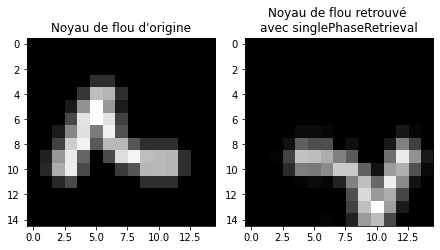

In [6]:
kernelFileName = 'ImagesNotebook/Kernel1.png' #on suppose un kernel carré
nIterations = 300
r = 4

kernel1 = skio.imread(kernelFileName, as_gray=True)
kernel = kernel1/np.sum(kernel1)
moduleH = np.abs(np.fft.fft2(kernel, s=(r*len(kernel), r*len(kernel[0]))))
retrievedKernel = singlePhaseRetrieval(moduleH, len(kernel), nIterations)

f, axarr = plt.subplots(1, 2,constrained_layout=True)
axarr[0].imshow(kernel, cmap="gray")
axarr[0].title.set_text("Noyau de flou d'origine")
axarr[1].imshow(np.abs(retrievedKernel), cmap="gray")
axarr[1].title.set_text("Noyau de flou retrouvé \navec singlePhaseRetrieval")
plt.show()

Si on éxecute plusieurs fois la cellule précédente, on s'aperçoit qu'on va parfois retrouver le bon noyau de flou, on va parfois obtenir ce noyau symétrisé, et on va parfois obtenir un résultat très différent du noyau original. L'algorithme suivant va nous permettre de résoudre ce problème pour retrouver le noyau de flou avec davantage de fiabilité.

## 4. Algorithme *phaseRetrieval*
Dans un deuxième temps, nous avons implementé l'algorithme *phaseRetrieval*, celui-ci utilise l'algorithme précédent plusieurs fois et sélectionne ensuite le meilleur des noyaux retrouvés. Nous avons précédemment vu que l'algorithme *singlePhaseRetrieval* a renvoie parfois notre noyau symétrisée (selon une symétrie centrale). Nous allons alors à chaque itération tester le noyau retrouvé par *singlePhaseRetrieval* et son symétrique. Nous allons ensuite calculer un coefficient de différence par rapport au noyau original, ce sont les coefficients *c* et *cReflect* dans la suite. On conserva donc le noyau retrouvé de plus petit coefficient de différence.

Pour cela, on fournit en entrée la densité spectrale de puissance du noyau de flou ainsi que la taille de ce noyau, ces deux données servent lors des appels à *singlePhaseRetrieval*. On fournit aussi l'image floutée (uniquement pour avoir sa taille) et deux paramètres pour faire varier le nombre d'itération de *singlePhaseRetrieval* et le nombre d'appel à cette fonction.

En sortie, on récupère le noyau sélectionné au terme des *nbtries* essais. 

In [7]:
def phaseRetrieval(moduleH, kernelSize, blurredImage, nbTries, nbIterations, v=False):
    
    #patch for the computation of c
    l = 150
    shape = blurredImage.shape
    center = (shape[0]/2, shape[1]/2)
    patch = blurredImage[int(center[0]-l/2):int(center[0]+l/2), int(center[1]-l/2):int(center[1]+l/2)]

    minCost = None
    minKernel = None
    
    for i in range(nbTries):
        kernel = singlePhaseRetrieval(moduleH, kernelSize, nbIterations)

        dec = skimage.restoration.richardson_lucy(patch, kernel[:, :, np.newaxis])

        #calcul de c
        absGrad = np.abs(np.gradient(dec))
        norme1 = np.sqrt(absGrad[0]**2 + absGrad[1]**2)
        c = (np.sum(norme1)/np.linalg.norm(norme1))

        #kernelReflect est la symétrie centrale de kernel (double symétrie axiale)
        kernelReflect = np.fliplr(np.flipud(kernel))
        decReflect = skimage.restoration.richardson_lucy(patch, kernelReflect[:, :, np.newaxis])

        #calcul de cReflect
        absGradReflect = np.abs(np.gradient(decReflect))
        norme1Reflect = np.sqrt(absGradReflect[0]**2 + absGradReflect[1]**2)
        cReflect = np.sum(norme1Reflect)/np.linalg.norm(norme1Reflect)

        if minCost == None:
            minCost = c
            minKernel = kernel
            if v : print('Itération ' + str(i) + ' :')
            if v : print('  Noyau normal avec c='+str(minCost))
        
        if minCost > c :
            minCost = c
            minKernel = kernel
            if v : print('Itération ' + str(i) + ' :')
            if v : print('  Noyau normal avec c='+str(minCost)) 

        if minCost > cReflect :
            minCost = cReflect
            minKernel = kernelReflect
            if v : print('Itération ' + str(i) + ' :')
            if v : print('  Noyau symétrisé avec c='+str(minCost))

    return minKernel

Pour sélectionner le meilleur noyau de flou, l'algorithme déconvolue l'image floutée avec le noyau de flou trouvé par *singlePhaseRetrieval* après chaque appel à cette fonction. On fait aussi cette opération avec la symétrie centrale du noyau de flou trouvé.

Le critère de sélection des noyaux est la minimisation de la fonction $c=\frac{l_1}{l_2}$ où $l_1$ est la norme 1 du gradient de l'image convuluée et $l_2$ sa norme 2. Cela revient à maximiser la variance de l'image et donc sa netteté.

On procède ensuite à plusieurs essais :
* On applique l'algorithme sur le même noyau que pour *singlePhaseRetrieval*
* On applique l'algorithme en changeant la taille du noyau (en mettant kernelSize plus grand ou plus petit que la vraie taille du noyau)

On introduit dans la cellule qui suit tous les paramètres modifiables sur lesquels se baseront les tests qui vont suivre. C'est notamment ici qu'on pourra modifier les noms de fichier pour changer de noyau de flou, ou d'image.

In [16]:
## Paramètres
imageFileName = 'ImagesNotebook/telecom1.jpg'
kernelFileName = 'ImagesNotebook/Kernel1.png'
nbIterations = 300 #pour singlePhaseRetrieval
nbTries = 30 #pour phaseRetrieval
r = 2 #facteur de multiplication de la taille du module de la TF du noyau

## Ouverture des images
imOriginal = skio.imread(imageFileName)
kernel1 = skio.imread(kernelFileName, as_gray=True)
kernel = kernel1/np.sum(kernel1)

## Calcul de l'image floutée
im = repeatedImage(imOriginal) #image périodisée
imBlurred = blurFromKernelTF(im, kernel) #image périodisée floutée
croppedBlur = cropRepeatedImage(imBlurred, 6) #image floutée (on rogne la périodisation)

Et voici le test de notre fonction *singlePhaseRetrieval*, qui renvoie la comparaison entre le noyau original et le noyau retrouvé par l'algorithme :

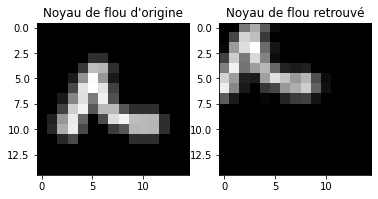

In [24]:
## Retrieve kernel
moduleH = np.abs(np.fft.fft2(kernel, s=(r*len(kernel), r*len(kernel[0]))))

retrievedKernel = phaseRetrieval(moduleH, len(kernel), croppedBlur, nbTries, nbIterations)


f, axarr = plt.subplots(1, 2)
axarr[0].imshow(kernel, cmap="gray")
axarr[0].title.set_text("Noyau de flou d'origine")
axarr[1].imshow(np.abs(retrievedKernel), cmap="gray")
axarr[1].title.set_text("Noyau de flou retrouvé")
plt.show()

Pour une taille de noyau raisonnable (ici 15 pixels) les résultats sont très satisfaisants. On retrouve le noyau original avec une très grande fidélité. La seule différence notable est la translation du noyau mais cela est indétéctable car cela revient à faire une translation de l'image et le critère utilisé pour choisir le noyau est invariant par translation.

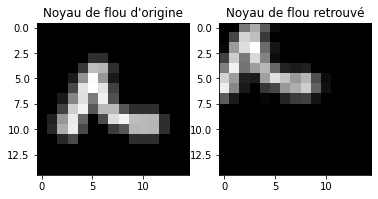

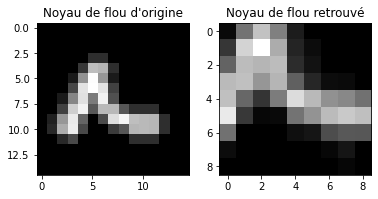

In [25]:
## Test with a bigger kernel size
moduleH = np.abs(np.fft.fft2(kernel, s=(r*len(kernel), r*len(kernel[0]))))

bigRetrievedKernel = phaseRetrieval(moduleH, len(kernel) + 6, croppedBlur, nbTries, nbIterations, v=False)


f, axarr = plt.subplots(1, 2)
axarr[0].imshow(kernel, cmap="gray")
axarr[0].title.set_text("Noyau de flou d'origine")
axarr[1].imshow(np.abs(retrievedKernel), cmap="gray")
axarr[1].title.set_text("Noyau de flou retrouvé")
plt.show()

## With a smaller kernel
moduleH = np.abs(np.fft.fft2(kernel, s=(r*len(kernel), r*len(kernel[0]))))

smallRetrievedKernel = phaseRetrieval(moduleH, len(kernel) - 6, croppedBlur, nbTries, nbIterations, v=False)


f, axarr = plt.subplots(1, 2)
axarr[0].imshow(kernel, cmap="gray")
axarr[0].title.set_text("Noyau de flou d'origine")
axarr[1].imshow(np.abs(smallRetrievedKernel), cmap="gray")
axarr[1].title.set_text("Noyau de flou retrouvé")
plt.show()

On voit que lorsque l'on prend *kernelSize* plus grand, ça ne pose pas de problème car le noyau réel passe toujours dans la fenêtre.

En revanche, prendre *kernelSize* plus petit fait que le noyau dépasse des bords et une partie de l'information de défloutage est perdue. Cependant on voit que la forme reste la même, juste rognée.

## 5. Test de défloutage en connaisant le module de la transformée de Fourier du noyau de flou
Maintenant que notre algorithme *phaseRetrieval* fonctionne, nous allons pouvoir tenter de déflouter une image. Comme *phaseRetrieval* a besoin du module de la transformée de Fourier du noyau de flou, et que nous n'avons pas d'algorithme pour l'estimer, nous ne pouvons pas déflouter n'importe quelle image.

Nous devons en effet partir d'une image nette, la flouter (par un produit de convolution), puis la déflouter en estimant le noyau de flou à partir de notre algorithme. Voici le résultat obtenu :

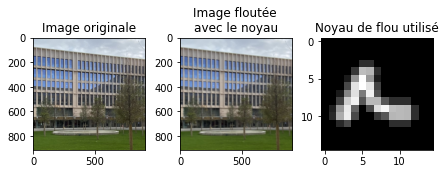

DÉMARRAGE DE PHASERETRIEVAL
DÉMARRAGE DE LA DÉCONVOLUTION


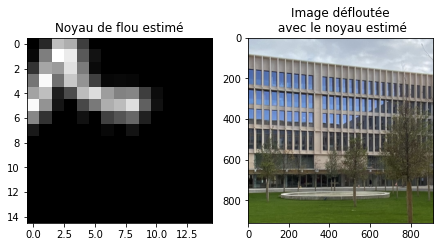

In [19]:
## Calcul du module de la transformée de Fourier du noyau de flou
fourier = np.fft.fft2(kernel, s=(r*len(kernel), r*len(kernel[0])))
moduleFourier = np.abs(fourier)

## Affichage
f, axarr = plt.subplots(1, 3,constrained_layout=True)
axarr[0].imshow(imOriginal, cmap="gray")
axarr[0].title.set_text("Image originale")
axarr[1].imshow(croppedBlur, cmap="gray")
axarr[1].title.set_text("Image floutée \navec le noyau")
axarr[2].imshow(kernel, cmap="gray")
axarr[2].title.set_text("Noyau de flou utilisé")
plt.show()


## Test de l'algortihme phaseRetrieval
print('DÉMARRAGE DE PHASERETRIEVAL')
retrievedKernel = phaseRetrieval(moduleFourier, len(kernel), imBlurred, nbTries, nIterations)
finalRetrievedKernel = retrievedKernel/np.sum(retrievedKernel)

## Déconvolution de l'image floue
print('DÉMARRAGE DE LA DÉCONVOLUTION')
decFinale = skimage.restoration.richardson_lucy(imBlurred, finalRetrievedKernel[:, :, np.newaxis])
croppedImage = cropRepeatedImage(decFinale, 6)

f, axarr = plt.subplots(1, 2,constrained_layout=True)
axarr[0].imshow(np.abs(finalRetrievedKernel), cmap="gray")
axarr[0].title.set_text("Noyau de flou estimé")
axarr[1].imshow(croppedImage)
axarr[1].title.set_text("Image défloutée\n avec le noyau estimé")
plt.show()

## 6. Estimation du module de la transformée de Fourier du noyau de flou

En regardant les résultats du paragraphe précédents, on s'aperçoit qu'on retrouve généralement un noyau assez similaire au vrai noyau dans la majorité des cas.

Cependant, les calculs précédents reposent sur le fait qu'on connait le module de la transformée de Fourier du noyau de flou, ce qui n'est pas le cas en pratique.

Bien qu'il soit trop long d'implémenter la méthode complète qui permette de retrouver le module de la transformée de Fourier du noyau de flou à partir de l'image floue seulement, nous allons dans ce paragraphe voir ce qui se passe lorsque nous le récupérons à partir de l'image floue et de l'image nette.

Pour cela, nous utilisons les relations suivantes :
Soit $i_f = i*k$ où $i_B$ représente l'image floue, convolution de l'image originale $i$ et du noyau de flou $k$.<br>
En appliquant la transformée de Fourier, on obtient $TF(i_f) = TF(i) \cdot TF(k)$<br>
D'où $|TF(k)| = \biggl |\dfrac{TF(i_f)}{TF(i)}\biggr |$ lorsque $TF(i)\ne0$.

La fonction suivante implémente cela, et nous utilisons des fenêtres de Hamming pour améliorer les résultats :

In [20]:
def hamming(im):
    imt=np.float32(im.copy())
    (ty,tx)=im.shape
    pi=np.pi
    XX=np.ones((ty,1))@(np.arange(0,tx).reshape((1,tx)))
    YY=(np.arange(0,ty).reshape((ty,1)))@np.ones((1,tx))
    imt=(1-np.cos(2*pi*XX/(tx-1)))*(1-np.cos(2*pi*YY/(ty-1)))*imt
    return imt

def kernelTFcalculation(image, imageBlurred):
    TFi = np.fft.fft2(hamming(image))
    TFib = np.fft.fft2(hamming(imageBlurred))
    TFK = TFib/TFi
    return TFK

Cependant, nous allons obtenir par cette méthode un noyau de flou qui a la même taille que l'image, alors qu'on souhaite obtenir un noyau de flou beaucoup plus petit.

Pour cela, il faut rogner le noyau obtenu pour le mettre à la taille réelle du noyau de flou (qu'on suppose connue). On peut ensuite calculer le module de sa transformée de Fourier pour obtenir ce que l'on souhaite.

On voit sur les résultats qui suivent qu'on arrive à avoir une excellente estimation du module de la transformée de Fourier du noyau de flou :

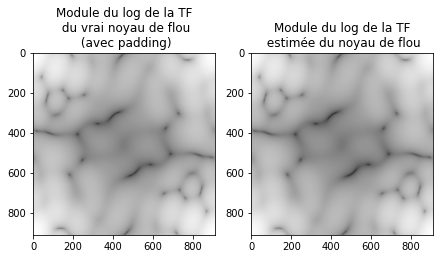

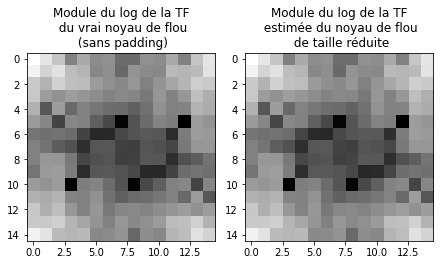

In [21]:
def estimateModuleTFK(imOriginal, imBlurred, v=True): #a besoin de la variable gloable kernel pour faire fonctionner l'affichage des résultats
    TFK = kernelTFcalculation(imOriginal[:,:,0]/255, cropRepeatedImage(imBlurred, 6)[:,:,0]/255)
    moduleFourier =np.abs(TFK) 

    if v:
        f, axarr = plt.subplots(1, 2,constrained_layout=True)
        axarr[0].imshow(np.log(abs(np.fft.fft2(kernel, s=(912,912)))), cmap='gray')#vrai noyau
        axarr[0].title.set_text('Module du log de la TF\n du vrai noyau de flou\n (avec padding)')
        axarr[1].imshow(np.log(moduleFourier), cmap='gray')#vrai noyau
        axarr[1].title.set_text('Module du log de la TF\n estimée du noyau de flou')
        plt.show()


    # Sous-échantillonage de la TF du noyau (il faut connaître len(kernel), et avoir des images carrées)
    n = len(kernel)
    m = len(imOriginal)

    bigK = np.real(np.fft.ifft2(TFK))
    bigK = np.real(np.fft.fftshift(bigK)) #centre le noyau
    smallK= bigK[int(m/2-n/2):int(m/2+n/2), int(m/2-n/2):int(m/2+n/2)]

    smallTFK = np.fft.fft2(smallK)
    smallModuleFourier = np.abs(smallTFK)
    
    f, axarr = plt.subplots(1, 2,constrained_layout=True)
    axarr[0].imshow(np.log(abs(np.fft.fft2(kernel))), cmap='gray')#vrai noyau
    axarr[0].title.set_text('Module du log de la TF\n du vrai noyau de flou\n (sans padding)')
    axarr[1].imshow(np.log(smallModuleFourier), cmap='gray')#vrai noyau
    axarr[1].title.set_text('Module du log de la TF\n estimée du noyau de flou\n de taille réduite')
    plt.show()
    
    return smallModuleFourier

        
test = estimateModuleTFK(imOriginal, imBlurred)

On peut maintenant observer l'influence du bruit sur l'image d'origine, et sur l'image floue. Est-ce que du bruit va significativement influencer le module de la transformée de Fourier du noyau de flou retrouvé ?
La réponse à cette question se trouve dans le résultat suivant *(on peut modifier la quantité de bruit ajouter en modifiant le paramètre noiseFactor)* :

Ajout de bruit sur l'image originale


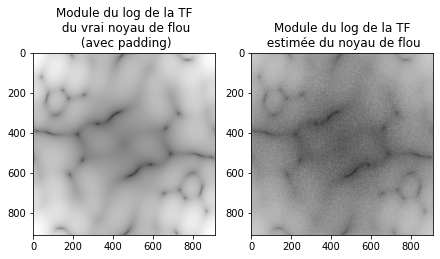

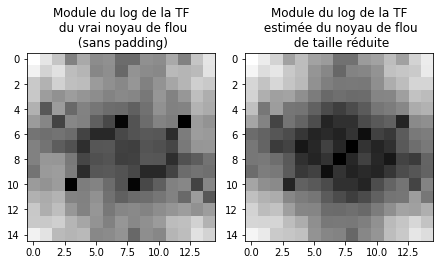

Ajout de bruit sur l'image bruitée


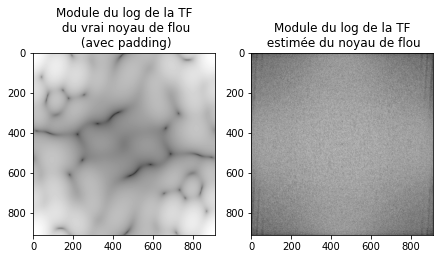

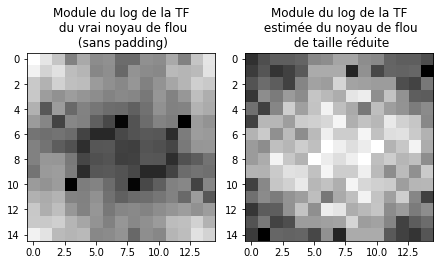

In [22]:
def noise(im,br): #ajoute un bruit blanc gaussien d'ecart type br à l'image im
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

noiseFactor = 10
print("Ajout de bruit sur l'image originale")
test = estimateModuleTFK(noise(imOriginal, noiseFactor), imBlurred)
print("Ajout de bruit sur l'image bruitée")
test = estimateModuleTFK(imOriginal, noise(imBlurred, noiseFactor))

On observe donc que l'ajout de bruit sur l'image originale semble se traduire en un ajout de bruit sur la transformée de Fourier du noyau de flou. On va donc avoir un noyau de flou estimé qui sera probablement un peu différent du noyau de flou initial.<br>
On observe également que l'ajout de bruit sur l'image floutée change complètement la transformée de Fourier estimée du noyau de flou, et on va probablement obtenir un noyau de flou qui n'a rien avoir avec l'original en poursuivant l'algorithme.

On calcule le résultat avec l'ajout de bruit sur l'image originale dans l'exemple suivant *(on peut modifier la quantité de bruit ajouter en modifiant le paramètre noiseFactor)* :

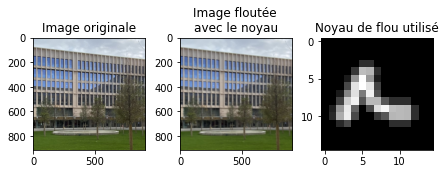

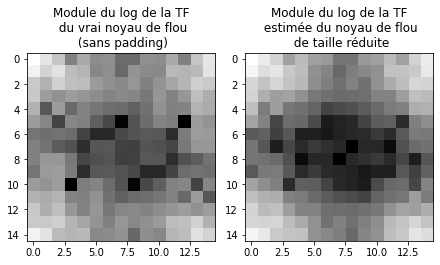

DÉMARRAGE DE PHASERETRIEVAL
DÉMARRAGE DE LA DÉCONVOLUTION


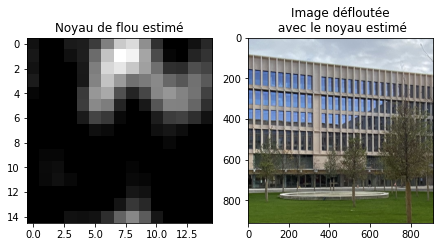

In [23]:
## Affichage
f, axarr = plt.subplots(1, 3,constrained_layout=True)
axarr[0].imshow(imOriginal, cmap="gray")
axarr[0].title.set_text("Image originale")
axarr[1].imshow(croppedBlur, cmap="gray")
axarr[1].title.set_text("Image floutée \navec le noyau")
axarr[2].imshow(kernel, cmap="gray")
axarr[2].title.set_text("Noyau de flou utilisé")
plt.show()

## Calcul du module du noyau
noiseBool = True # Bruitage de l'image originale si True
noiseFactor = 10
smallModuleFourier = estimateModuleTFK(noise(imOriginal, noiseFactor), imBlurred, v=False)

## Test de l'algortihme phaseRetrieval
print('DÉMARRAGE DE PHASERETRIEVAL')
retrievedKernel = phaseRetrieval(smallModuleFourier, len(kernel), imBlurred, nbTries, nIterations)
finalRetrievedKernel = retrievedKernel/np.sum(retrievedKernel)


## Déconvolution de l'image floue
print('DÉMARRAGE DE LA DÉCONVOLUTION')
decFinale = skimage.restoration.richardson_lucy(imBlurred, finalRetrievedKernel[:, :, np.newaxis])
croppedImage = cropRepeatedImage(decFinale, 6)

f, axarr = plt.subplots(1, 2,constrained_layout=True)
axarr[0].imshow(np.abs(finalRetrievedKernel), cmap="gray")
axarr[0].title.set_text("Noyau de flou estimé")
axarr[1].imshow(croppedImage)
axarr[1].title.set_text("Image défloutée\n avec le noyau estimé")
plt.show()

Finalement, on voit que l'ajout de bruit sur l'image d'origine vient perturber le calcul du module de la transformée de Fourier du noyau de flou, qui va dégrader le noyau de flou estimé par l'algorithme.

En effet, le résultat précédent montre que le noyau de flou estimé apparait moins net que le vrai noyau. Il semble plus flou et moins précis. À la déconvolution, on voit que l'image est quand même nettement améliorée (par rapport à l'image floue), car le noyau de flou, bien que moins net, conserve la forme générale du vrai noyau.

Ainsi, notre méthode est sensible au bruit, mais elle peut y résister dans une certaine mesure.

## 7. Résultats et conclusion
Pendant ce projet, nous avons implementé les dernières étapes de l'algorithme de Goldstein-Fattal. Dans sa globalité l'algorithme permet de retrouver le noyau de flou qu'une image a subit uniquement à partir de l'image floutée.
Ce noyau se décompose en deux parties : le module et la phase de sa transformée de fourier. Nous avons implémenté la récupération de la phase à partir du module.

Les résultats obtenus sont conforment à ceux attendus à la lecture de l'article. On arrive à retrouver la phase du noyau à partir du module de manière très fidèle lorsque le module est exact et que l'on connait la taille du noyau d'origine.

Nous avons ensuite essayé l'algorithme mais en demandant une taille de noyau retrouvé differente de la vraie taille du noyau. Dans ce cas, le noyau retrouvé est toujours bon mais soit entouré d'une bordure noire (dans le cas d'une sur estimation de la taille du noyau) ou bien le noyau retrouvé est rogné (dans le cas d'une sous-estimation de la taille du noyau).

Les derniers essais que nous avons realisé consitent à vérifier que notre algorithme est résistant au bruit dans l'image. Nous avons ajouté du bruit à l'image floutée avant de calculer le module de la TF du noyau. On applique ensuite l'algorithme *phaseRetrieval*. Le noyau retrouvé perd de ses details et devient presque une tâche au centre. Cela s'explique par le fait que le bruit a plus d'impact sur les hautes fréquences naturellement faible dans l'image et donc sur les détails de l'image.